In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import modeling_utils, DynamicCache
from tqdm import tqdm
from copy import deepcopy
import json
import time


if not hasattr(modeling_utils, "ALL_PARALLEL_STYLES") or modeling_utils.ALL_PARALLEL_STYLES is None:
    modeling_utils.ALL_PARALLEL_STYLES = ["tp", "none","colwise",'rowwise']
%matplotlib inline
# use retina mode
%config InlineBackend.figure_format = 'retina'

In [4]:
# Load model and tokenizer
device = "cuda:3"
model_name = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)

think_token = "</think>"
think_token_id = tokenizer.encode(think_token, add_special_tokens=False)[0]

Unrecognized keys in `rope_scaling` for 'rope_type'='yarn': {'attn_factor'}


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model_solutions_dir = '/root/tts_and_entropy/model_solutions/dpsk_new_with_sample_long.json'
model_solutions_dpsk_long_with_sample = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions_dpsk_long_with_sample.append(json.loads(line.strip()))

R = model_solutions_dpsk_long_with_sample[188]['response']
R = R.split('</think>')[0]
header = R.split("<think>")[0] + '<think>\n'
reasoning_line = R.split("<think>")[1].split('\n\n')
reasoning_line[0] = reasoning_line[0][1:]  

In [6]:
INTERVAL = 1
with torch.no_grad():
    next_token_entropy = []
    entropies = []
    bi_gram_entropies = []
    cache = DynamicCache()
    for i in range(len(reasoning_line) + 1)[::INTERVAL]:
        partial_answer = (header + "\n\n".join(reasoning_line[:i]))
        inputs_big = tokenizer(partial_answer, return_tensors="pt")['input_ids'].to(device)
        if cache is not None:
            inputs = inputs_big[:, cache.get_seq_length():]
        model_outputs = model(
            inputs,
            output_hidden_states=False,
            return_dict=True,
            cache=True,
            past_key_values=cache if cache is not None else None,
        )
        cache = model_outputs.past_key_values

In [7]:
CACHE_ENT = deepcopy(cache)

lengths = [
    8000, 6000, 4000, 2000, 1000, 500
    # 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2
    # 10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000, 500, 250, 125
]
all_times = []

with torch.no_grad():
    for i in range(len(lengths)):
        inputs = tokenizer("\n</think>\n" + 'Final answer: ', return_tensors="pt")['input_ids'].to(device)
        _time = []
        for _ in range(10):
            CACHE_ENT.crop(lengths[i])
            st = time.time()
            model_outputs = model(
                inputs,
                past_key_values=CACHE_ENT
            )
            et = time.time()
            _time.append(et - st)
        all_times.append(_time)

Text(0.5, 0, 'Reasoning chain length (#tokens)')

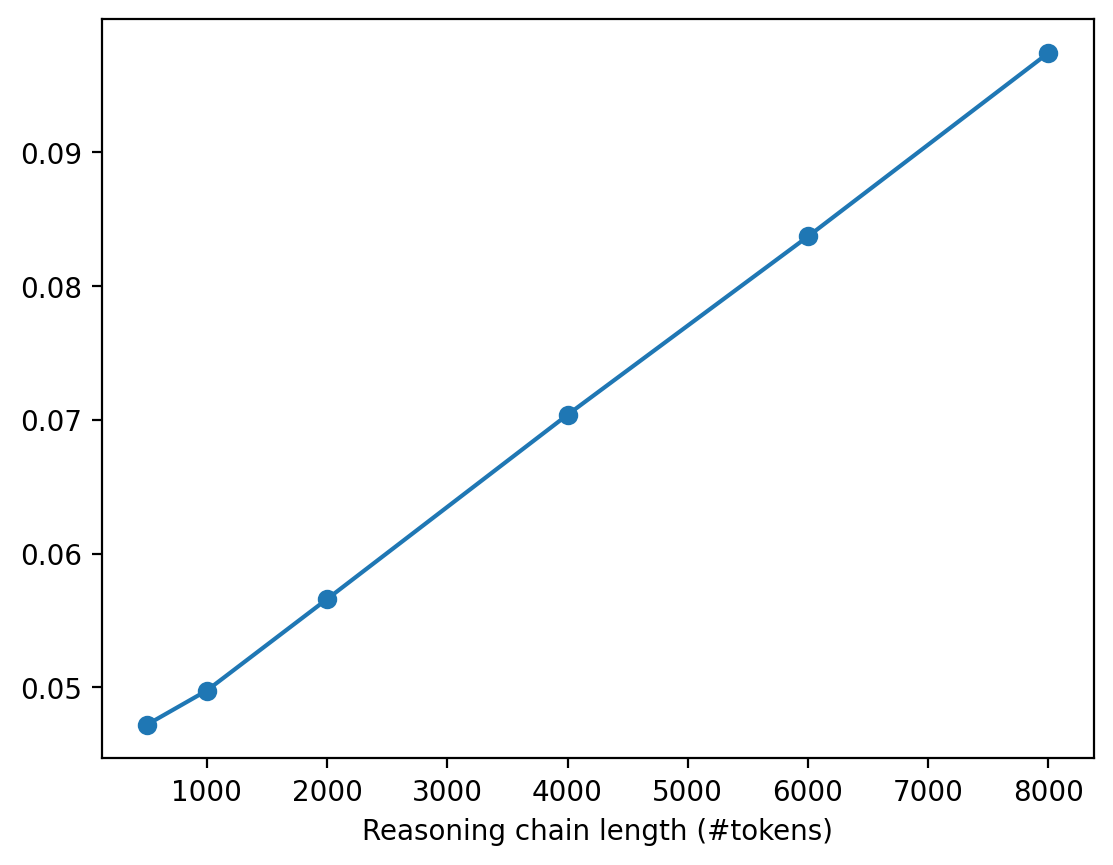

In [8]:
plt.plot(lengths[::-1], np.array(all_times).mean(1)[::-1], marker='o')
plt.xlabel('Reasoning chain length (#tokens)')

In [ ]:
np.save('')

In [9]:
rollout_runtime = np.load(
    '/root/tts_and_entropy/runtime_results/rollout_times_1.npy',
)

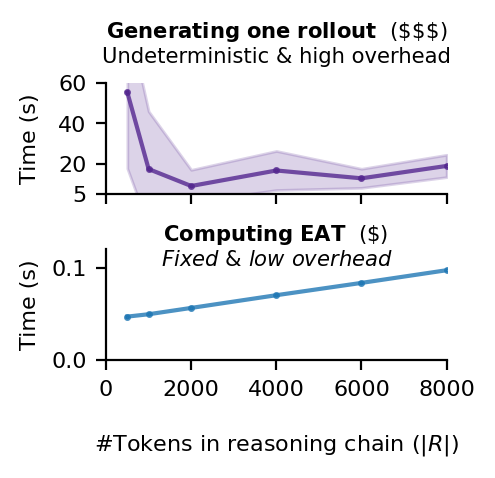

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(2.2, 1.8), sharex='col')

line_args = {
    'marker': 'o',
    'markersize': 1.5,
    'linewidth': 1.5,
    'alpha': 0.8,
}

FSIZE = 8

fig.subplots_adjust(hspace=0.5)

for a in ax:
    a.tick_params(labelsize=FSIZE)
    a.set_ylabel('Time (s)', fontsize=FSIZE)
    a.set_xlim(0, 8010)
    # Remove frame
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    # a.spines['left'].set_visible(False)
    # a.spines['bottom'].set_visible(False)
    # a.set_ylim(0, )

ax[0].set_ylim(5, 60)
ax[0].set_yticks([5, 20, 40, 60])

ax[1].set_ylim(0, 0.12)

ax[1].set_xlabel('#Tokens in reasoning chain ' + r'$(|R|)$', fontsize=FSIZE, labelpad=12.0)
    # a.grid(True, linestyle='--', alpha=0.5)

ax[0].plot(lengths[::-1], rollout_runtime.mean(1)[::-1],
            c='#54278f',
            **line_args)
ax[0].fill_between(lengths[::-1], 
                 rollout_runtime.mean(1)[::-1] - rollout_runtime.std(1)[::-1],
                 rollout_runtime.mean(1)[::-1] + rollout_runtime.std(1)[::-1],
                 alpha=0.2, color='#54278f')

ax[1].plot(lengths[::-1], np.array(all_times).mean(1)[::-1], **line_args)

ax[0].set_title(r'$\bf Generating~$' +r'$\bf{one~rollout}$' + '  (\$\$\$)' + '\nUndeterministic & high overhead', fontsize=7.6, y=1.03)
ax[1].set_title( r'$\bf Computing$'+ r'$~\bf EAT$' + '  (\$)' + ' \n' + '$\it Fixed~&~low~overhead$', fontsize=7.6, y=0.7)

# ax[0].text(1.1, 0.9,
#            r'$\bf Generating$' + '\n' + r'$\bf one~rollout$' + '\nUndeterministic\n& high overhead',
#            transform=ax[0].transAxes,
#            fontsize=FSIZE * .95, va='top', ha='left', color='black')
# ax[1].text(1.1, 0.8,
#            r'$\bf Computing$'+ r'$~\bf EAT$' + '\nFixed & low\noverhead\n\n',
#         #    '\n\nTime complexity:\n' + r'$\mathcal{O}(|R|)$',
#            transform=ax[1].transAxes,
#            fontsize=FSIZE * .95, va='top', ha='left', color='black')

fig.align_ylabels()

fig.savefig(
    '/root/figures/eat_vs_rollout_time.pdf', bbox_inches='tight'    
)

In [ ]:
# CACHE_ROLLOUT = cache

# lengths = [
#     8000, 6000, 4000, 2000, 1000, 500
#     # 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2
# ]
# all_times_rollouts = []

# with torch.no_grad():
#     for i in range(len(lengths)):
#         inputs = tokenizer("\n</think>\nFinal answer:", return_tensors="pt")['input_ids'].to(device)
#         _time = []
#         for _ in range(10):
#             CACHE_ROLLOUT.crop(lengths[i])
#             st = time.time()
#             rollouts = model.generate(
#                 torch.concat([
#                     inputs_big[:, :lengths[i]],
#                     inputs
#                 ], 1),
#                 max_new_tokens=500,
#                 do_sample=True,
#                 temperature=0.6,
#                 use_cache=True,
#                 past_key_values=CACHE_ROLLOUT,
#                 output_scores=False,
#                 return_dict_in_generate=True,
#                 top_k=None,
#                 top_p=None,
#             )
#             et = time.time()
#             _time.append(et - st)
#         all_times_rollouts.append(_time)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end gene

In [ ]:
np.save('/root/tts_and_entropy/estimate_time_rollouts.npy', np.array(all_times_rollouts), )

In [ ]:
len(lengths)dd

13

In [11]:
len(all_times_rollouts)

13

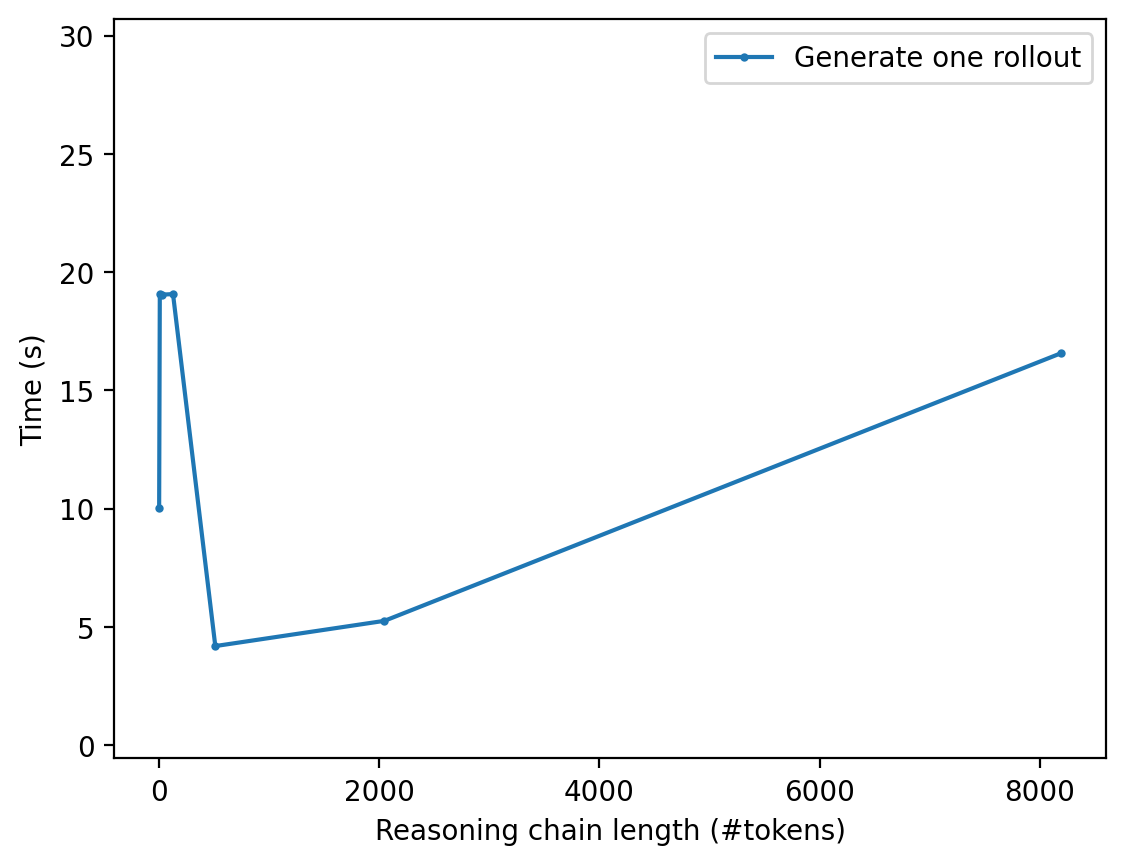

In [20]:
plt.plot(lengths[::-1][::2], np.array(all_times_rollouts).mean(1)[::-1][::2], marker='o', markersize=2, label='Generate one rollout')
plt.fill_between(lengths[::-1], np.array(all_times_rollouts).mean(1)[::-1] - np.array(all_times_rollouts).std(1)[::-1],
                 np.array(all_times_rollouts).mean(1)[::-1] + np.array(all_times_rollouts).std(1)[::-1], alpha=0.2)

# plt.plot(lengths[::-1], np.array(all_times).mean(1)[::-1], marker='o', markersize=2, label='Compute EAT')
plt.xlabel('Reasoning chain length (#tokens)')
plt.ylabel('Time (s)')
plt.legend()
# plt.ylim(0, 0.1)
# plt.xscale('log')
# plt.yscale('log')